In [1]:
# 1) Using simulated scaling laws
# - confirm that first derivative threshold is independent of the model size
# - finding the derivative thresholds we need:
# == optimality: -0.052
# == growing the depth: -0.0575
# == growing the width: -0.0475
# - confirm that `S_befor_grow = constant_op * S_of_grown_model_at_same_loss` is independent of the model size
# - finding the ratios
# == constant_op_width: 2.717
# == constant_op_depth: 1.831


# 2) Using real learning curves
# - find thresholds, ratios and expected compute saving. This gives us enough information 
#   to develop a training schedule for any model size N
# - thresholds turns out to match those from the scaling laws listed above
# - ratios are different:
# == constant_op_width: 1.81
# == constant_op_depth: 1.43


# 3) To replace the oracle, here's our training procedure for the width operator as an example
# 1. train smaller model until first derivative threshold_width is reached
# 2. get `S_of_grown_model_at_same_loss` from the equation above
# 3. grow the model, start it from step S_of_grown_model_at_same_loss
# 4. train grown model until threshold_optimality is reached
# 5. end

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import pandas as pd

# Table 5 in Appendix A
B_star = 2.1e8
S_c = 2.1e3
N_c = 8.8e13
alpha_B = 0.21   
alpha_N = 0.076
alpha_S = 0.76

def L_at_convergence(N):  # loss at convergence given model size (eq 1.1)
    return (N_c / N)**alpha_N


def L_given_size_and_steps(N, S):  # loss give model size and number of steps (eq 1.6)
    return (N_c / N)**alpha_N + (2 * S_c / S)**alpha_S


def Bcrit_give_L(L): #  critical batch size at a given Loss (eq 5.3)
    return B_star / (L ** (1 / alpha_B))


def C_in_PFDay(c):  # Notations section 1.3
    return c / (8.64 * 10**19) 


def C_given_N_B_S(N, B, S):
    return 6 * N * B * S  # after equation 5.5

In [13]:

# Helper functions to get derivatives 
def _diff(x, stride=1):
    # like np.diff, but allows a stride longer then 1
    return x[stride:] - x[0:-stride]

def _running_mean(x, window_size=2):
    from scipy.ndimage.filters import uniform_filter1d
    return uniform_filter1d(x, size=window_size)    

def _get_index_of_point_at_first_derivative_threshold(compute, val_loss, threshold):
    diff_stride = 1
    window_size = 5

    log_compute = np.log10(compute)
    log_val_loss = np.log10(val_loss)

    x = log_compute
    y = _running_mean(log_val_loss, window_size)

    first_derivative = _diff(y, diff_stride) / _diff(x, diff_stride)

    min_value = min(first_derivative)
    index_min_value = np.where(first_derivative == min_value)[0][0]
    for i, val in enumerate(first_derivative[index_min_value:]):
        if val > threshold:
            print(val, threshold, index_min_value, i, val_loss[i+index_min_value])
            break
            
    return i + index_min_value

In [4]:

def draw_learning_curve_for_N_with_derivative_threshold(N, threshold):
    '''
    Given model size, plot learning curve assuming critical batch size.
    Highlight a point in the curve that curresponds to the given first derivative threshold
    '''
    Smin = range(4000, 90000, 10)  # number of training steps
    L_at_N = [L_given_size_and_steps(N, s) for s in Smin]
    Bcrit = [Bcrit_give_L(l) for l in L_at_N ]
    C = [C_given_N_B_S(N, bcrit, smin) for bcrit, smin in  zip(Bcrit, Smin)]  # S = 2Smin @ Bcrit (eq 5.4)
    C = [C_in_PFDay(c) for c in C]
    plt.plot(C, L_at_N)

    threshold_point_index = _get_index_of_point_at_first_derivative_threshold(C, L_at_N, threshold=threshold)
    plt.annotate(".", (C[threshold_point_index], L_at_N[threshold_point_index]), arrowprops={'arrowstyle': '-'})
    return Smin, C, L_at_N, threshold_point_index

In [5]:
# Derivative thresholds  (found using manual search)
threshold_optimality = -0.052
threshold_depth_growth = -0.0575
threshold_width_growth = -0.0475

In [7]:

def get_ratio_and_saving(run_before_grow, run_after_grow):
    before_steps, before_computes, before_losses, before_threshold_point_index = run_before_grow
    after_steps, after_computes, after_losses, after_threshold_point_index = run_after_grow
    
    loss_at_grow = before_losses[before_threshold_point_index]

    index_after_grow = min(enumerate(after_losses), key=lambda x: abs(x[1]-loss_at_grow))[0]
    
    compute_from_scratch = after_computes[after_threshold_point_index]
    compute_before_grow = before_computes[before_threshold_point_index]
    compute_at_growing_point = after_computes[index_after_grow]
    compute_saving = (compute_at_growing_point - compute_before_grow) / compute_from_scratch
    ratio = before_steps[before_threshold_point_index] / after_steps[index_after_grow]
    plt.annotate(".", (after_computes[index_after_grow], loss_at_grow), arrowprops={'arrowstyle': '-'})

    print(f'Saving: {compute_saving:0.3f}, '
          f'S-before-growing: {before_steps[before_threshold_point_index]}, '
          f'S@grow: {after_steps[index_after_grow]}, '
          f'constant_op: {ratio:0.3f}, '
          f'L@growing: {loss_at_grow:0.3f}, '
          f'S-to-optimality: {after_steps[after_threshold_point_index]}'
    )
    return compute_saving, ratio


In [8]:
def remove_loss_spikes(steps, losses):
    """If next loss is significanlty higher than previous loss, it is a spike, remove it."""
    prev_loss = 100000
    cleaned_steps = []
    cleaned_losses = []
    for step, loss in zip(steps, losses):
        is_outlier = False
        if loss > prev_loss:
            if (loss - prev_loss) / prev_loss > 0.01:
                is_outlier = True 
        if not is_outlier:
            prev_loss = loss
            cleaned_steps.append(step)
            cleaned_losses.append(loss)
        else:
            # print(f'removing: {step} {loss} {(loss - prev_loss) / prev_loss}')
            pass
    return cleaned_steps, cleaned_losses
        
        
def get_logs(filename, token_per_iter):
    # returns List[float], List[float] with the number of tokens processed and val loss
    data = pd.read_csv(filename)
    res = data['Value'].tolist()
    step = data['Step'].tolist()
    step, res = remove_loss_spikes(step, res)
    number_tokens_processed = [s * token_per_iter for s in step]
    return number_tokens_processed, res, step


def get_loss_vs_compute_steps(filename, batch_size, model: str, dtype=np.float64):
    number_tokens_processed, loss, step = get_logs(filename, batch_size)
    number_parameters = models[model][0]
    compute_per_token = 6 * number_parameters
    compute = np.array(number_tokens_processed, dtype=dtype) * compute_per_token
    return compute, np.array(loss, dtype=dtype), step

# # Not used but maybe we should
# def smooth(x, alpha=0.9):
#     ret = np.zeros(x.shape)
#     ret[0] = x[0]
#     for k in range(1, len(x)):
#         ret[k] = ret[k - 1] * (1.0 - alpha) + alpha * x[k]
#     return ret

In [9]:
root = '../data'
filenames = glob.glob(f'{root}/*')
runs = {
    'GPT2_base': {"filename": 'base_logs/run-no_warmup_bs_gpt2_10_8_check_bs512_lr0.0021_warmup3k_seqlen1024_debug_version_0_tf-tag-val_loss.csv',
    "model":'GPT2_base'},
    'GPT2_large': {"filename": 'large_logs/run-no_warmup_bs_gpt2_10_9_check_bs512_lr0.0021_warmup3k_seqlen1024_debug_version_0_tf-tag-val_loss.csv',
    "model":'GPT2_large'},
    'GPT2_base_div4': {"filename": 'base_logs/run-real_no_warmup_bs_gpt3_10_7_check_bs512_lr0.0022_warmup3k_seqlen1024_debug_version_0_tf-tag-val_loss.csv',
    "model":'GPT2_base_div4'},
    'GPT2_large_div4': {"filename": 'large_logs/run-no_warmup_bs_gpt3_10_8_d24_check_bs512_lr0.0021_warmup3k_seqlen1024_debug_version_0_tf-tag-val_loss.csv',
    "model":'GPT2_large_div4'},
    'GPT2_large_div2_depth': {"filename": 'large_logs/run-no_warmup_bs_gpt3_10_9_d12_check_bs512_lr0.0023_warmup3k_seqlen1024_debug_version_0_tf-tag-val_loss.csv',
    "model":'GPT2_large_div2_depth'},
    'GPT2_base_div2_depth': {"filename": 'base_logs/run-new_no_warmup_bs_gpt3_10_8_d6_check_bs512_lr0.0021_warmup3k_seqlen1024_debug_version_0_tf-tag-val_loss.csv',
    "model":'GPT2_base_div2_depth'},
}
models = {
    "GPT2_base_div4": (12*(384*4*384 + 384*384*4*2), 45, 70, 5, 7),
    "GPT2_base": (12*(768*4*768 + 768*768*4*2), 45, 70, 5, 7),
    "GPT2_base_div2_depth": (6*(768*4*768 + 768*768*4*2), 45, 70, 5, 7),
    "GPT2_short": (6*(768*4*768 + 768*768*4*2), 45, 70, 5, 7),
    "GPT2_base_real": (12*(768*4*768 + 768*768*4*2), 45, 70, 5, 7),
    "GPT2_shallow": (12*(384*4*384 + 384*384*4*2), 45, 70, 5, 7),
    "GPT2_large_div4": (24*(768*4*768 + 768*768*4*2), ), 
    "GPT2_large": (24*(1536*4*1536 + 1536*1536*4*2), ), 
    "GPT2_large_div2_depth": (12*(1536*4*1536 + 1536*1536*4*2), ), 
    "GPT2_wide": (12*(3072*4*3072 + 3072*3072*4*2), ), 
}

run_pairs_depth = [('GPT2_base_div2_depth', 'GPT2_base'),
                   ('GPT2_large_div2_depth', 'GPT2_large'),]
run_pairs_width = [('GPT2_base_div4', 'GPT2_base'),
                   ('GPT2_large_div4', 'GPT2_large'),]

batch_size = 512 * 1024

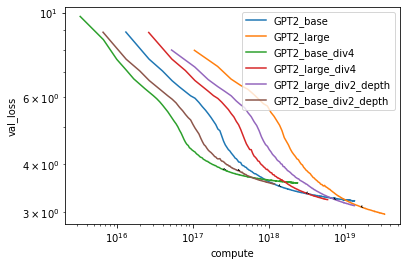

In [10]:

def draw_and_get_model(run, threshold):
    compute, val_loss, steps = get_loss_vs_compute_steps(f"{root}/{run['filename']}", batch_size, run['model'])
    threshold_point_index = _get_index_of_point_at_first_derivative_threshold(compute, val_loss, threshold=threshold)
    plt.loglog(compute, val_loss, label=run['model'])
    plt.annotate(".", (compute[threshold_point_index], val_loss[threshold_point_index]), arrowprops={'arrowstyle': '-'})
    return steps, compute, val_loss, threshold_point_index

for run in runs.values():
    draw_and_get_model(run, threshold=threshold_optimality)

plt.xlabel('compute')
plt.ylabel('val_loss')
plt.legend()
plt.show()

In [20]:
def get_const_op_and_savings(run1, run2, threshold1, threshold2):
    before_steps, before_computes, before_losses, before_optimal_point_index = draw_and_get_model(run1, threshold1)
    after_steps, after_computes, after_losses, after_optimal_point_index = draw_and_get_model(run2, threshold2)
    loss_at_jump = before_losses[before_optimal_point_index]
    index_after_jump = min(enumerate(after_losses), key=lambda x: abs(x[1]-loss_at_jump))[0]
    compute_from_scratch = after_computes[after_optimal_point_index]
    compute_before_jump = before_computes[before_optimal_point_index]
    compute_at_jump_point = after_computes[index_after_jump]
    compute_saving = (compute_at_jump_point - compute_before_jump) / compute_from_scratch
    plt.annotate(".", (after_computes[index_after_jump], loss_at_jump), arrowprops={'arrowstyle': '-'})
    print(round(compute_saving, 3), before_steps[before_optimal_point_index],
          after_steps[index_after_jump], after_steps[after_optimal_point_index],
          before_steps[before_optimal_point_index] / after_steps[index_after_jump],
          threshold1, threshold2, before_steps[before_optimal_point_index] / (constant_op_depth), before_steps[before_optimal_point_index] / (constant_op_width))
    return compute_saving

compute saving, steps before grow, steps after grow, steps from scratch to optimality, const_op, threshold1, threshold2
GPT2_base_div2_depth GPT2_base
-0.04820559731441831 -0.0575 17 40 3.850097179412842
-0.04396397858332934 -0.052 18 82 3.5098118782043457
0.132 2949 2149 5099 1.372266170311773 -0.0575 -0.052 2062.237762237762 1629.2817679558011
GPT2_large_div2_depth GPT2_large
-0.05163644693454416 -0.0575 13 122 3.2410688400268555
-0.04589842983735191 -0.052 14 139 3.0910651683807373
0.148 6799 4549 7749 1.49461420092328 -0.0575 -0.052 4754.545454545455 3756.3535911602207


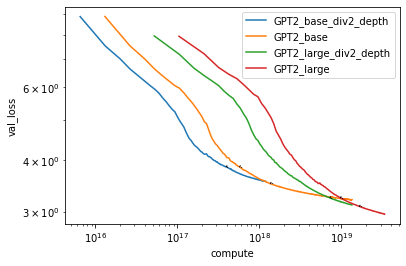

compute saving, steps before grow, steps after grow, steps from scratch to optimality, const_op, threshold1, threshold2
GPT2_base_div4 GPT2_base
-0.04608750607540638 -0.0475 20 54 3.87304949760437
-0.04396397858332934 -0.052 18 82 3.5098118782043457
0.216 3799 2049 5099 1.854075158613958 -0.0475 -0.052 2656.6433566433566 2098.8950276243095
GPT2_large_div4 GPT2_large
-0.0449700109743033 -0.0475 16 109 3.3411827087402344
-0.04589842983735191 -0.052 14 139 3.0910651683807373
0.255 6299 3549 7749 1.774866159481544 -0.0475 -0.052 4404.895104895105 3480.110497237569


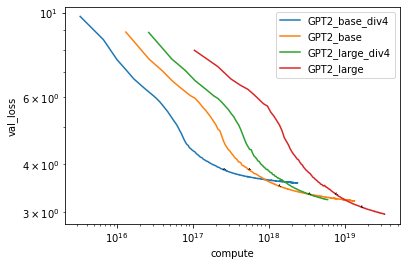

In [21]:
# Find constant_op_depth and constant_op_width
# constant_op_depth: 1.433440185617527
# constant_op_width: 1.814470659047751

constant_op_depth =  1.43
constant_op_width =  1.81

print('compute saving, steps before grow, steps after grow, steps from scratch to optimality, const_op, threshold1, threshold2')
for from_model, to_model in run_pairs_depth:
    from_model_record = runs[from_model]
    to_model_record = runs[to_model]
    print( from_model, to_model )
    compute_saving = get_const_op_and_savings(from_model_record, to_model_record,
                                              threshold_depth_growth, threshold_optimality)
plt.xlabel('compute')
plt.ylabel('val_loss')
plt.legend()
plt.show()

print('compute saving, steps before grow, steps after grow, steps from scratch to optimality, const_op, threshold1, threshold2')
for from_model, to_model in run_pairs_width:
    from_model_record = runs[from_model]
    to_model_record = runs[to_model]
    print( from_model, to_model )
    compute_saving = get_const_op_and_savings(from_model_record, to_model_record,
                                              threshold_width_growth, threshold_optimality)
plt.xlabel('compute')
plt.ylabel('val_loss')
plt.legend()
plt.show()